In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import Isomap

## Grid Environment

In [2]:
class BasicGridEnv:
    
    def __init__(self, height, width, start = None):
        self.height = height
        self.width = width
        if start == None:
            self.start = lambda: (np.random.randint(width), np.random.randint(height))
        else:
            self.start = lambda: start
        
    def reset(self):
        self.current_loc = self.start()
        self.num_steps = 0
    
    def step(self, action):
        self.num_steps += 1
        x,y = self.current_loc
        if action == 0:
            self.current_loc = (x, y + 1) #up
        elif action == 1:
            self.current_loc = (x + 1, y) #right
        elif action == 2:
            self.current_loc = (x, y - 1) #down
        elif action == 3:
            self.current_loc = (x - 1, y) #left
        else:
            raise ValueError("invalid action")
            
    def random_step(self):
        in_bounds = False
        current_loc = self.current_loc
        while not in_bounds:
            self.current_loc = current_loc
            action = np.random.randint(0, 4)
            self.step(action)
            in_bounds = self.in_bounds(self.current_loc)
    
    def in_bounds(self, loc):
        x,y = loc
        if x < 0 or x >= self.width or y < 0 or y >= self.height:
            return False
        return True

In [3]:
class OneWayTeleporterGridEnv(BasicGridEnv):
    
    def __init__(self, height, width, teleporter_loc_start, teleporter_loc_end, start = None):
        super().__init__(height, width, start)
        self.teleporter_loc_start = teleporter_loc_start
        self.teleporter_loc_end = teleporter_loc_end
        
    def step(self, action):
        if self.current_loc == self.teleporter_loc_start and self.num_steps > 0:
            self.current_loc = self.teleporter_loc_end
        else:
            super().step(action)
    

In [4]:
class TwoWayTeleporterGridEnv(BasicGridEnv):
    
    def __init__(self, height, width, teleporter_loc_1, teleporter_loc_2, start = None):
        super().__init__(height, width, start)
        self.teleporter_loc_1 = teleporter_loc_1
        self.teleporter_loc_2 = teleporter_loc_2
        self.just_teleported = False
        
    def reset(self):
        super().reset()
        self.just_teleported = False
        
    def step(self, action):
        if self.current_loc == self.teleporter_loc_1 and not self.just_teleported:
            self.current_loc = self.teleporter_loc_2
            self.just_teleported = True
        elif self.current_loc == self.teleporter_loc_2 and not self.just_teleported:
            self.current_loc = self.teleporter_loc_1
            self.just_teleported = True
        else:
            super().step(action)
            if self.just_teleported:
                self.just_teleported = False

In [5]:
env_height, env_width = 30, 30
teleporter_start, teleporter_end = (2, 2), (17, 17)
start_loc = teleporter_start
env = TwoWayTeleporterGridEnv(env_height, env_width, teleporter_start, teleporter_end)

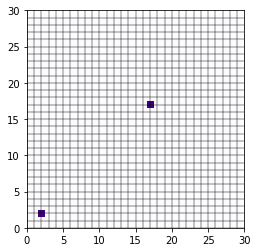

In [6]:
grid = np.zeros(shape = (env_height,env_width))
grid[teleporter_start[0], teleporter_start[1]] = 0.5
grid[teleporter_end[0], teleporter_end[1]] = 0.5

plt.imshow(grid, cmap = "Purples", origin = "lower")
for i in range(env_height):
    plt.vlines(i, 0, env_height, alpha = 0.3)
    plt.hlines(i, 0, env_width, alpha = 0.3)
plt.ylim(0,env_height)
plt.xlim(0,env_width);

## Random Indexing with Ternary Vectors

In [7]:
# define representations
np.random.seed(42)
embedding_dim = 10000
k_sparse = 10
N = 1500
M = env.height * env.width


D = np.zeros(shape = (N, embedding_dim))
for i in range(N):
    label = np.zeros(shape = (embedding_dim))
    nonzero_indxs = np.random.randint(0, embedding_dim, size = k_sparse * 2)
    one_indxs = nonzero_indxs[:k_sparse]
    neg_one_indxs = nonzero_indxs[k_sparse:]
    label[one_indxs] = 1
    label[neg_one_indxs] = -1
    D[i,:] = label

K = np.zeros(shape = (M, N))
W = np.zeros(shape = (M, embedding_dim))

In [8]:
# sampling from environment

num_episodes = N
episode_length = 150

for j in range(num_episodes):
    env.reset()
    for _ in range(episode_length):
        env.random_step()
        x,y = env.current_loc
        loc_indx = env.height * y + x
        K[loc_indx, j] += 1
        

In [9]:
# learn embedding

W = K.dot(D)

## Visualize Embeddings

In [10]:
#distance functions

def cosine_distance(v1, v2):
    
    if np.sum(v1) == 0 or np.sum(v2) == 0:
        return 0
    
    num = v1.dot(v2)
    denom = np.linalg.norm(v1, ord = 2) * np.linalg.norm(v2, ord = 2)
    return num/denom

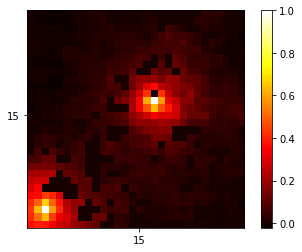

In [11]:
# heatmap

heatmap = np.zeros(shape = (env.height, env.width))
fixed_point = (teleporter_start)
fixed_indx = env.height * fixed_point[1] + fixed_point[0]

for y in range(env.height):
    for x in range(env.width):
        loc_indx = env.height * y + x
        v1 = W[fixed_indx]
        v2 = W[loc_indx]
        similarity = cosine_distance(v1, v2)
        heatmap[y, x] = similarity
        
plt.imshow(heatmap, cmap = "hot", origin = "lower");
plt.colorbar()
plt.xticks([15])
plt.yticks([15]);

In [12]:
#Manifold learning with Isomap

normalized_embeddings = np.zeros(shape = W.shape)
for i in range(W.shape[0]):
    norm = np.linalg.norm(W[i,:], ord = 2)
    if norm != 0:
        normalized_embeddings[i,:] = W[i,:] / norm
manifold = Isomap(n_components=3).fit_transform(W)

<IPython.core.display.Javascript object>


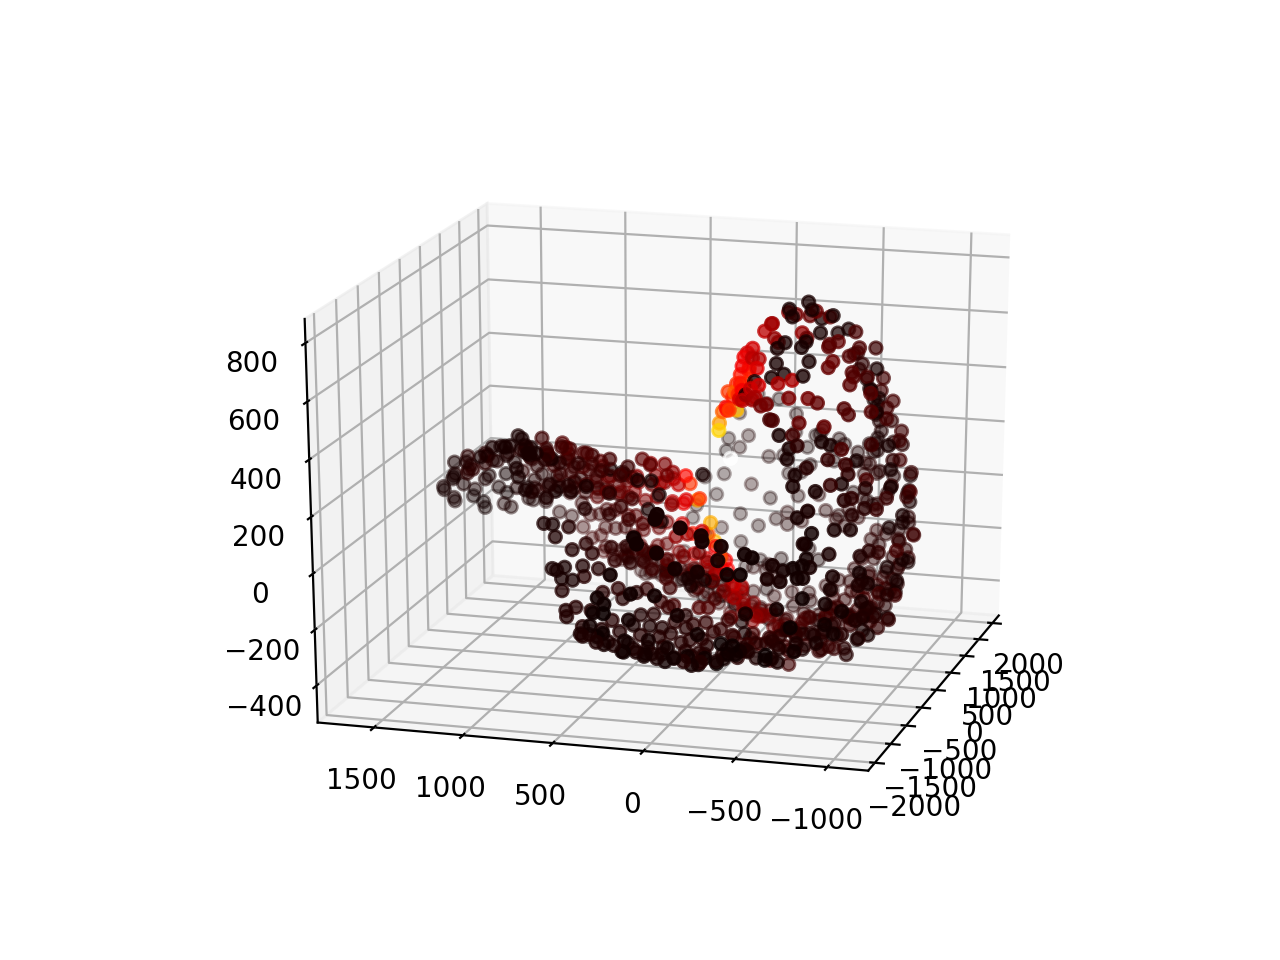

In [13]:
%matplotlib notebook 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs = manifold[:, 0], ys = manifold[:, 1], zs = manifold[:, 2], c = heatmap.flatten(), cmap = "hot");

## Four Rooms Environment

In [14]:
class FourRoomEnv(BasicGridEnv):
    
    def __init__(self, height, width, wall_x, wall_y, doors, start = None):
        super().__init__(height, width, start)
        
        self.wall_x = wall_x
        self.wall_y = wall_y
        self.doors = doors
            
    def reset(self):
        self.num_steps = 0
        done = False
        while not done:
            self.current_loc = self.start()
            done = self.in_bounds(self.current_loc)
    
    def in_bounds(self, loc):
        x,y = loc
        if x < 0 or x >= self.width or y < 0 or y >= self.height:
            return False
        elif self.at_wall(loc):
            return False
        return True
    
    def at_wall(self, loc):
        x,y = loc
        if (x == self.wall_x or y == self.wall_y) and (not self.at_door(loc)):
            return True
        return False
    
    def at_door(self, loc):
        for door in self.doors:
            if loc == door:
                return True
        return False

<IPython.core.display.Javascript object>


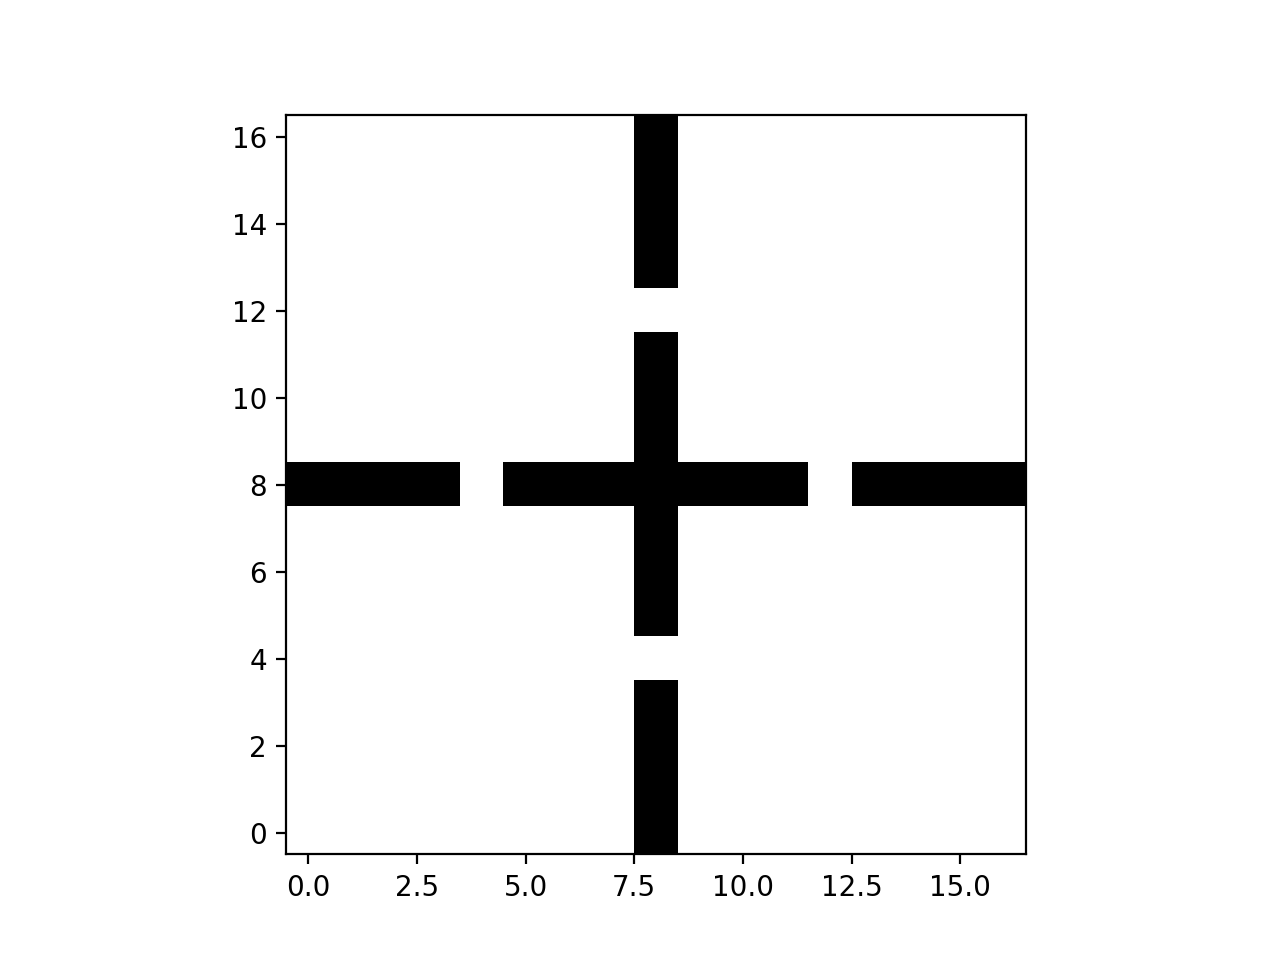

In [15]:
env_height, env_width = 17, 17
wall_x, wall_y = 8,8
doors = [(4,8), (8,4), (12,8), (8,12)]
start_loc = (0,0)

env = FourRoomEnv(env_height, env_width, wall_x, wall_y, doors)

grid = np.zeros(shape = (env.height, env.width))
for j in range(env.height):
    for i in range(env.width):
        loc = (j,i)
        in_bounds = env.in_bounds(loc)
        grid[j,i] = in_bounds
        
plt.imshow(grid, cmap = "gray", origin = "lower");

In [16]:
# define representations

np.random.seed(42)
embedding_dim = 10000
k_sparse = 10
N = 3000
M = env.height * env.width


D = np.zeros(shape = (N, embedding_dim))
for i in range(N):
    label = np.zeros(shape = (embedding_dim))
    nonzero_indxs = np.random.randint(0, embedding_dim, size = k_sparse * 2)
    one_indxs = nonzero_indxs[:k_sparse]
    neg_one_indxs = nonzero_indxs[k_sparse:]
    label[one_indxs] = 1
    label[neg_one_indxs] = -1
    D[i,:] = label

K = np.zeros(shape = (M, N))
W = np.zeros(shape = (M, embedding_dim))

In [17]:
# sampling from environment

num_episodes = N
episode_length = 150

for j in range(num_episodes):
    env.reset()
    for _ in range(episode_length):
        env.random_step()
        x,y = env.current_loc
        loc_indx = env.height * y + x
        K[loc_indx, j] += 1

In [18]:
# learn embedding

W = K.dot(D)

<IPython.core.display.Javascript object>


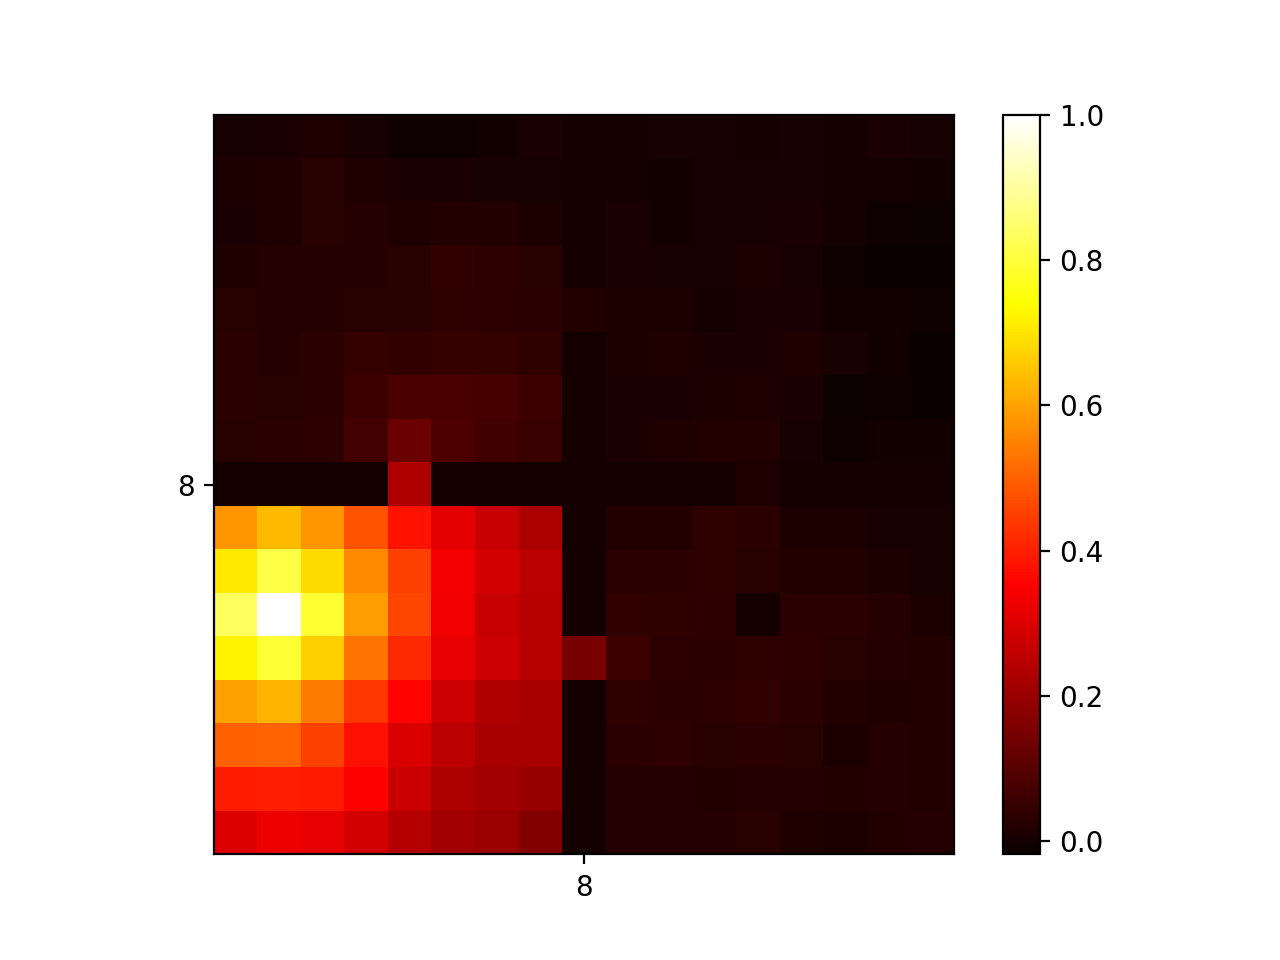

In [19]:
# heatmap

heatmap = np.zeros(shape = (env.height, env.width))
fixed_point = (1,5)
fixed_indx = env.height * fixed_point[1] + fixed_point[0]

for y in range(env.height):
    for x in range(env.width):
        loc_indx = env.height * y + x
        v1 = W[fixed_indx]
        v2 = W[loc_indx]
        similarity = cosine_distance(v1, v2)
        heatmap[y, x] = similarity
        
plt.imshow(heatmap, cmap = "hot", origin = "lower");
plt.colorbar()
plt.xticks([env.width // 2])
plt.yticks([env.height // 2]);

In [20]:
#ISOMAP

normalized_embeddings = np.zeros(shape = W.shape)
for i in range(W.shape[0]):
    norm = np.linalg.norm(W[i,:], ord = 2)
    if norm != 0:
        normalized_embeddings[i,:] = W[i,:] / norm
manifold = Isomap(n_components=2).fit_transform(W)

<IPython.core.display.Javascript object>


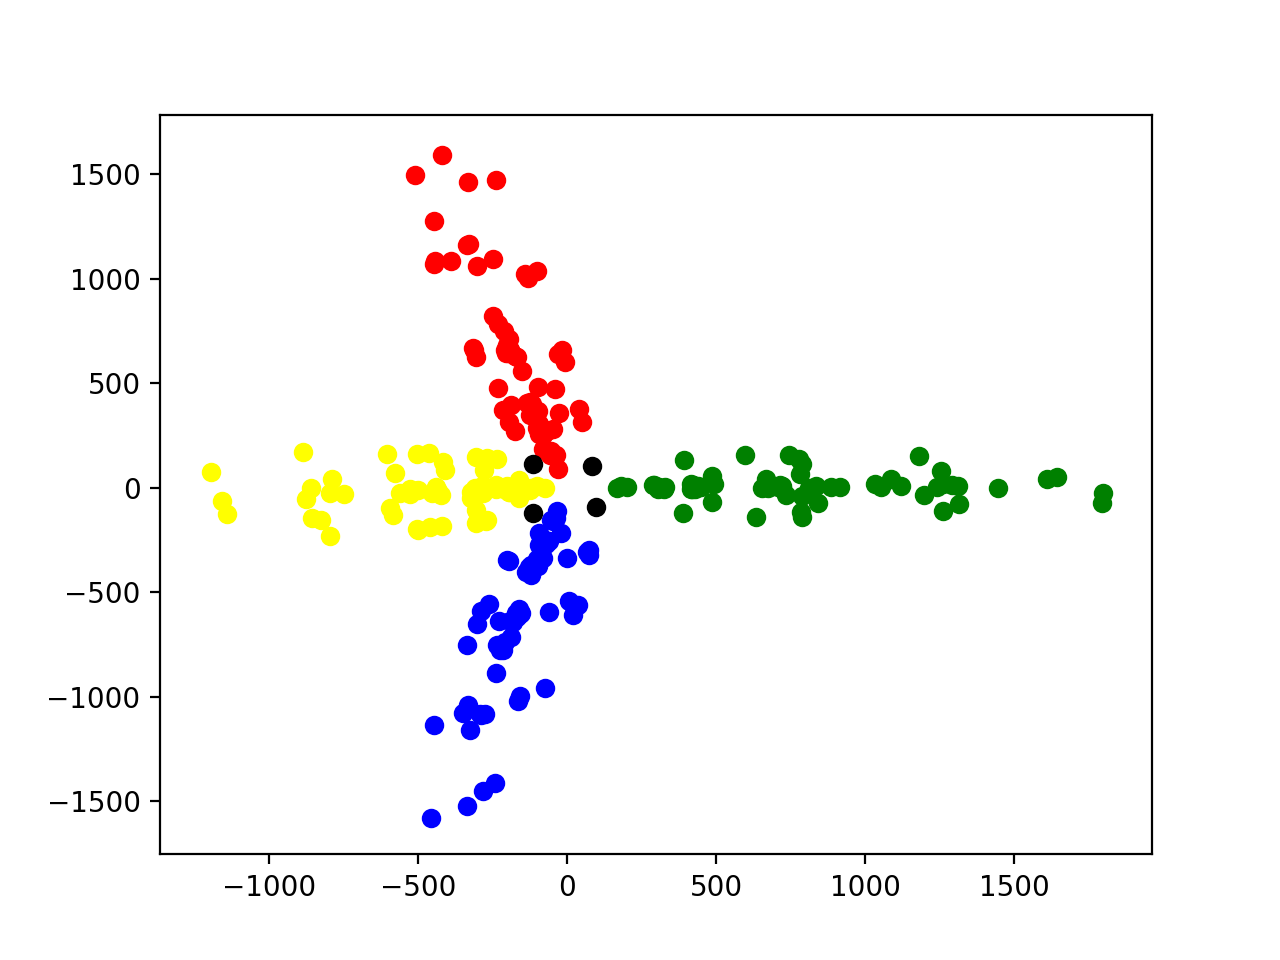

In [21]:
for y in range(env.height):
    for x in range(env.width):
        loc = (x,y)
        loc_indx = env.height * y + x
        if env.in_bounds(loc):
            if env.at_door(loc):
                plt.scatter(x = manifold[loc_indx, 0], y = manifold[loc_indx, 1], c = "black")
            elif x <= 8 and y <= 8:
                plt.scatter(x = manifold[loc_indx, 0], y = manifold[loc_indx, 1], c = "blue")
            elif x >= 8 and y <= 8:
                plt.scatter(x = manifold[loc_indx, 0], y = manifold[loc_indx, 1], c = "green")
            elif x <= 8 and y >= 8:
                plt.scatter(x = manifold[loc_indx, 0], y = manifold[loc_indx, 1], c = "yellow")
            elif x >= 8 and y >= 8:
                plt.scatter(x = manifold[loc_indx, 0], y = manifold[loc_indx, 1], c = "red")
            else:
                print("weird")

In [22]:
# want to try 3d next

normalized_embeddings = np.zeros(shape = W.shape)
for i in range(W.shape[0]):
    norm = np.linalg.norm(W[i,:], ord = 2)
    if norm != 0:
        normalized_embeddings[i,:] = W[i,:] / norm
manifold = Isomap(n_components=3).fit_transform(W)

<IPython.core.display.Javascript object>


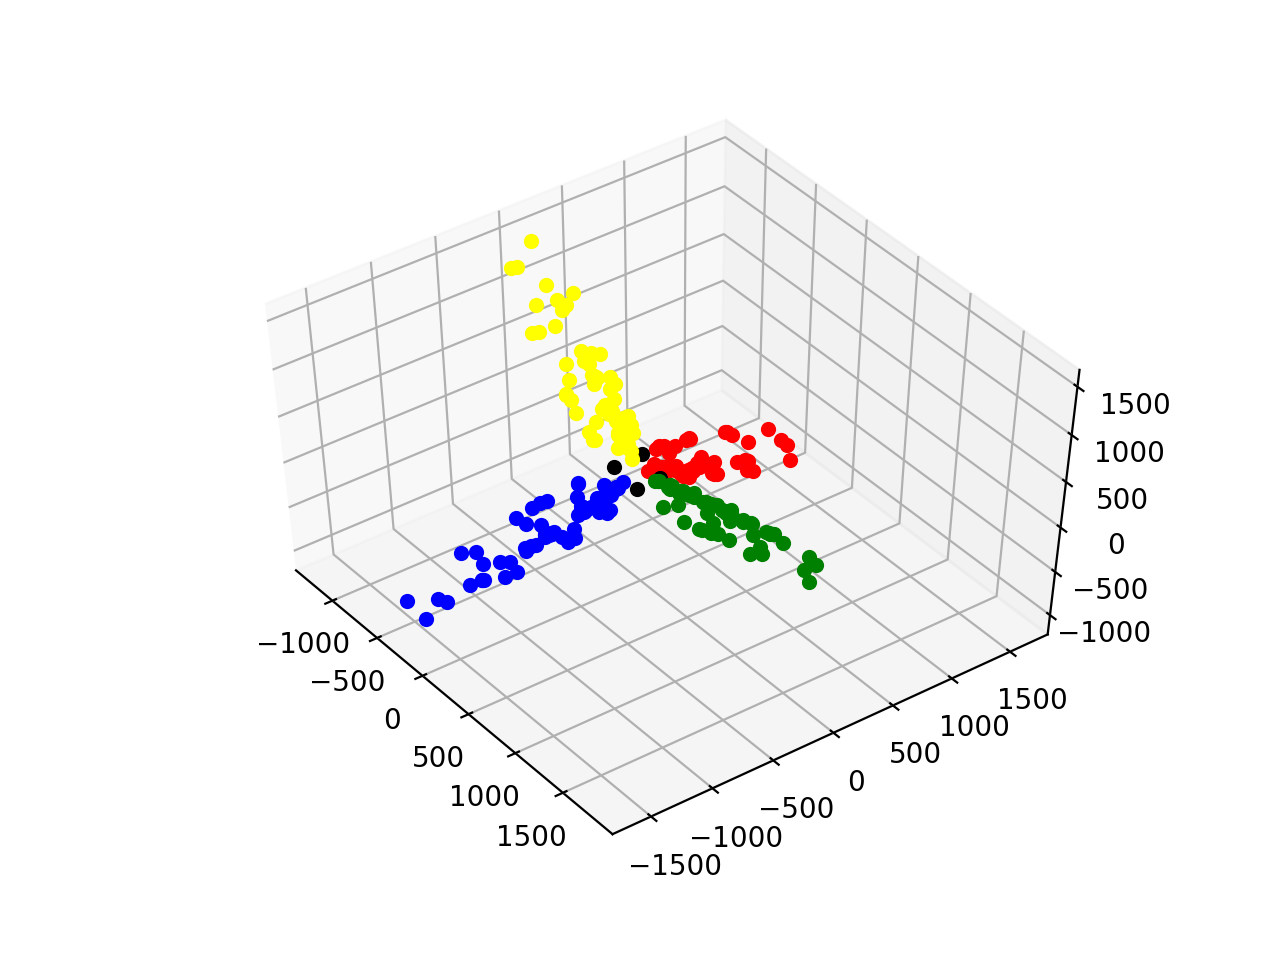

In [23]:
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for y in range(env.height):
    for x in range(env.width):
        loc = (x,y)
        loc_indx = env.height * y + x
        if env.in_bounds(loc):
            if env.at_door(loc):
                ax.scatter(xs = manifold[loc_indx, 0], ys = manifold[loc_indx, 1], zs = manifold[loc_indx,2], c = "black")
            elif x <= 8 and y <= 8:
                ax.scatter(xs = manifold[loc_indx, 0], ys = manifold[loc_indx, 1], zs = manifold[loc_indx,2], c = "blue")
            elif x >= 8 and y <= 8:
                ax.scatter(xs = manifold[loc_indx, 0], ys = manifold[loc_indx, 1], zs = manifold[loc_indx,2], c = "green")
            elif x <= 8 and y >= 8:
                ax.scatter(xs = manifold[loc_indx, 0], ys = manifold[loc_indx, 1], zs = manifold[loc_indx,2], c = "yellow")
            elif x >= 8 and y >= 8:
                ax.scatter(xs = manifold[loc_indx, 0], ys = manifold[loc_indx, 1], zs = manifold[loc_indx,2], c = "red")
            else:
                print("weird")